In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [2]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
# Show only a subset of the columns
X[X.columns[::3]].head()

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005670,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


In [3]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

In [4]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [5]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

In [6]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5208.250639,5212.341949
21.542052,4928.018900,4936.201520
15.034077,4869.678359,4881.952289
6.189631,4815.437362,4831.802601
5.329616,4810.423641,4830.880191
4.306012,4803.573491,4828.121351
4.124225,4804.126502,4832.765671
3.820705,4803.621645,4836.352124


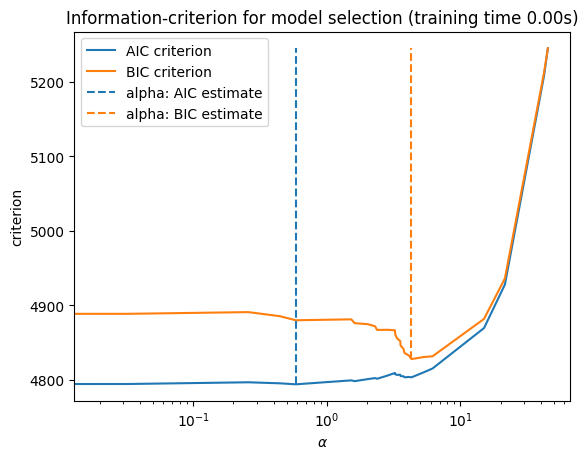

In [7]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

In [8]:
from sklearn.linear_model import LassoCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

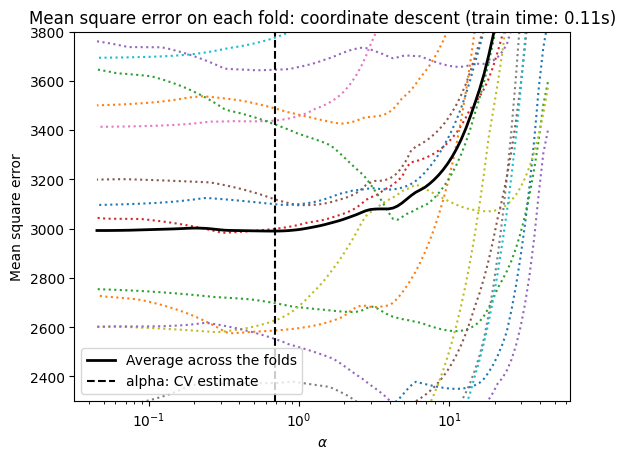

In [9]:
import matplotlib.pyplot as plt

ymin, ymax = 2300, 3800
lasso = model[-1]
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

In [10]:
from sklearn.linear_model import LassoLarsCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

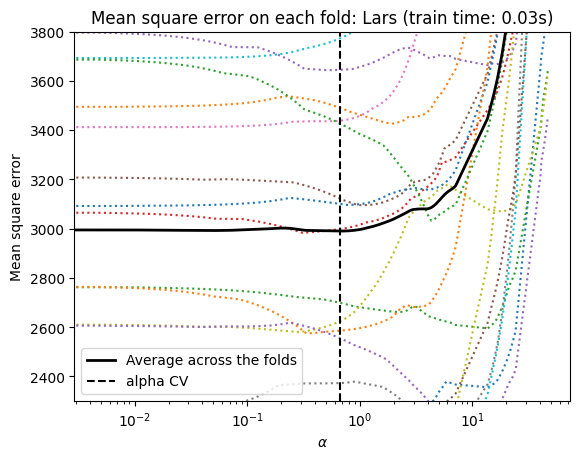

In [11]:
lasso = model[-1]
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_, ":")
plt.semilogx(
    lasso.cv_alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha CV")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(f"Mean square error on each fold: Lars (train time: {fit_time:.2f}s)")